## Import Python Libraries

In [1]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing, metrics
import geopandas as gpd
import fiona
import requests
import zipfile
import io

%matplotlib inline
from matplotlib import pyplot as plt

## Bring in the Data


### Download a shapefile of county boundaries from Census for the US and load it into a GeoPandas DataFrame

In [2]:
def download_shapefile(directory):
    """
    Download county boundaries from census.gov ftp site. Unzips file and loads it into a geoPandas dataframe
    
    """          
    map_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    #print('Downloading shapefile...')
        
    # Split on the rightmost / and take everything on the right side of that
    name = map_url.rsplit('/', 1)[-1]
    
    # Remove newline characters from URL
    filename = name.replace("\n", "")
        
    file_zip = os.path.join(directory,filename)
    
    r = requests.get(map_url)
    with open(file_zip, "wb") as code:
        code.write(r.content)
    
    z=zipfile.ZipFile(file_zip).extractall(directory)
        
    nation_file_shp = file_zip.replace(".zip",".shp")
        
    # Read into geoPandas Dataframe   
    nation = gpd.read_file(nation_file_shp)
    
    return nation

In [3]:
us_counties = download_shapefile("C:\\Projects\\junk\\Florida")

## Select State of interest for analysis to using FIPS codes to make a new GeoDataFrame

In [6]:
def select_state(fips, nation):
    """
    Creates new GeoDataFrame based on FIPS code
    
    fips:the 2-digit FIPS code for your state you of interest
    nation: GeoDataFrame of census counties
    """
    counties = nation.loc[nation['STATEFP'] == '{0}'.format(fips)].squeeze() 
    counties = counties.rename(columns={'GEOID': 'geoId'})
    
    #return counties
    return counties

In [7]:
counties_gdf = select_state(12, us_counties)

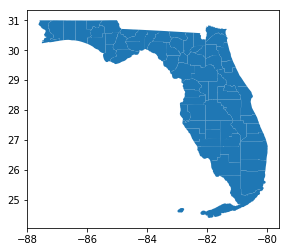

In [9]:
counties_gdf.plot()

### Use request.get to load data requested from API into a Response object. Use Requests builtin JSON decoder to read JSON data and load it into a Pandas dataframe.

In [10]:
def create_dataframe(fips,early_year,late_year):
    """
    Submits request for data to the API and creates formatted pandas dataframe for use with clustering algorithms
    
    fips = string defining the 2-digit FIPS code for your state you of interest
    early_year = string defining the 1st date of change period (1996, 2001, 2006 or 2010)
    late_year = string defining the 2nd date of change period (1996, 2001, 2006 or 2010)
    """
    # Format inputs for url
    fips = "'{}'".format(fips)
    early_year = "'{}'".format(early_year)
    late_year = "'{}'".format(late_year)
    
    #API request for Land Cover data in JSON format
    url = "https://coast.noaa.gov/opendata/LandCover/api/v1/distributionOfChangeGainsLossesByLandcovers?$filter=startswith(geoId, {0}) and length(geoId) eq 5 and earlyYear eq {1} and lateYear eq {2}".format(fips, early_year, late_year)
    
    r = requests.get(url, headers={'Accept': 'application/json'})
    data = r.json()
    lca_df = pd.DataFrame(data['value'])
    
    # Set index to the FIPS code and drop Early and Late Year Fields
    lca_df_index = lca_df.set_index('geoId').drop(['earlyYear', 'lateYear'], axis=1)
    
    return lca_df_index


In [12]:
FL_2001_2010 = create_dataframe(12,2001,2010)

In [13]:
FL_2001_2010.head()

,AgrAreaGain,AgrAreaLoss,BarAreaGain,BarAreaLoss,EmwAreaGain,EmwAreaLoss,ForAreaGain,ForAreaLoss,GrsAreaGain,GrsAreaLoss,...,LIDAreaGain,LIDAreaLoss,OSDAreaGain,OSDAreaLoss,SscbAreaGain,SscbAreaLoss,WdwAreaGain,WdwAreaLoss,WtrAreaGain,WtrAreaLoss
geoId,,,,,,,,,,,,,,,,,,,,,
12001,0.80,-11.10,1.13,-0.40,5.05,-5.03,36.34,-43.42,27.53,-19.90,...,2.98,-0.11,2.59,-0.52,30.35,-29.37,4.70,-4.63,1.35,-0.64
12003,0.00,-0.46,0.99,-0.18,5.06,-1.41,32.86,-51.60,26.59,-26.34,...,0.47,-0.03,0.28,-0.07,39.12,-22.13,1.40,-5.16,0.30,-0.14
12005,1.41,-2.11,3.79,-3.32,6.24,-6.29,14.16,-45.35,18.26,-20.57,...,2.14,-0.31,2.28,-0.54,46.29,-18.31,8.65,-8.44,0.52,-1.05
12007,0.08,-1.39,0.51,-0.41,3.30,-1.70,20.31,-24.41,15.33,-10.91,...,0.14,-0.01,0.11,-0.02,16.07,-15.54,1.62,-3.32,0.25,-0.08
12009,0.33,-6.48,1.44,-0.16,9.13,-8.06,1.83,-0.41,1.20,-1.65,...,5.90,-0.45,4.57,-1.54,7.22,-1.36,1.44,-26.43,7.71,-0.84


### Create Pandas DataFrame with County Names and Fips Codes from GeoPandas DataFrame

In [14]:
def create_fips_table(dataframe):
    """
    Creates table of FIPS codes and county names for joining to Land Cover DataFrame
    
    dataframe: Geopandas dataframe of State of interest
    
    """
    
    county_attributes = pd.DataFrame(dataframe)
    fips_names = county_attributes[['geoId','NAMELSAD']]
    fips_names.columns = ['geoId','name']
    
    return fips_names

In [15]:
fips_df = create_fips_table(counties_gdf)

### Perform K-means Cluster Analysis

In [18]:
def kmeans_cluster(dataframe, min_cluster, max_cluster):
    """
    Runs a user-defined range of k-means clusters and plots iniertia to help user determine optimal number of clusters
    
    dataframe: Name of pandas dataframe being used for cluster analysis
    min_cluster: Minimum number of clusters
    max_cluster: Maximum number of clusters
    
    """
    clusters = range(min_cluster, max_cluster)
    inertias = []
    
    for k in clusters:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)
    
        # Fit model to samples
        model.fit(dataframe)
         
        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)
        
    # Plot inertias
    plt.plot(inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(clusters)
    plt.show()
    
    

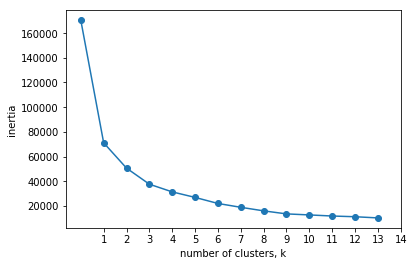

In [19]:
fl_clusters = kmeans_cluster(FL_2001_2010,1,15)

In [20]:
def kmeans_optimal(dataframe,n_clusters):
    """
    Runs a k-means cluster analysis and returns labels based on the optimal number of clusters
    
    dataframe: Name of pandas dataframe being used for cluster analysis
    n_cluster: Number of clusters
       
    """
    # Create a KMeans instance with X # of clusters: model
    model = KMeans(n_clusters)

    # Fit model to points
    model.fit(dataframe)

    # Determine the cluster labels of new_points: labels
    labels = model.predict(dataframe)
    
    # Print cluster labels of new_points
    print(labels)
    print('Inertia:', model.inertia_)
    print ('Silhouette Score:', metrics.silhouette_score(dataframe, labels, metric='euclidean'))
    
    return labels

In [21]:
optimal_cluster = kmeans_optimal(FL_2001_2010, 5)

[4 4 4 1 0 0 4 0 0 1 0 4 0 4 1 4 1 0 1 1 0 1 4 0 0 0 0 3 1 0 4 1 4 3 3 1 4
 1 4 3 4 0 0 0 4 4 0 3 3 3 0 0 3 1 1 0 2 0 0 0 4 2 1 1 0 2 1]
Inertia: 31322.674120833333
Silhouette Score: 0.38030883315696073


In [22]:
def map_clusters(labels,dataframe):
    """
    Takes labels from k-means clustering and joins them to Geopandas DataFrame
    
    lables: labels from k-means clustering
    dataframe: Name of pandas dataframe being used for cluster analysis
    """
    labels_dict = {'label':labels}
    labels_df = pd.DataFrame(labels_dict, index=dataframe.index)

    counties_cluster=counties_gdf.join(labels_df, on='geoId')
    
    cluster_plot = counties_cluster.plot(figsize=(15, 15), column='label', legend=True)
    cluster_plot.set_axis_off()
    
    return counties_cluster
       

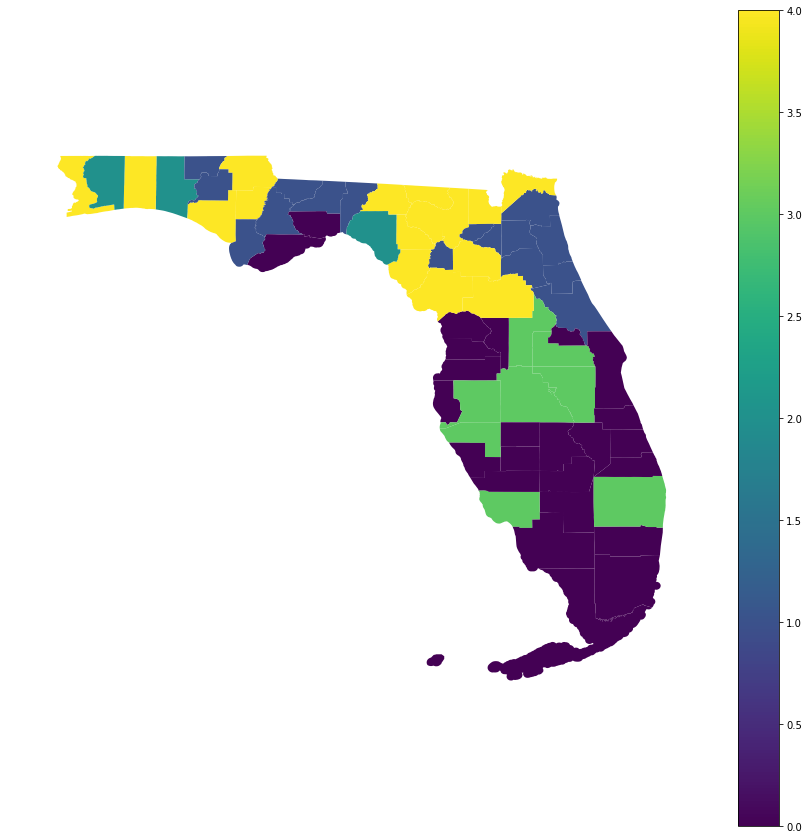

In [23]:
cluster_map = map_clusters(optimal_cluster,FL_2001_2010)